<a href="https://colab.research.google.com/github/hariprasathmurugesan/ColabSheets/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit : Many to One Sequence Problem

Skim lit aim is to read the complete paper and then categorize the entire chunk of text into several categoris including
1. Objective
2. Abstract
3. Background
4. Methods
5. Observations
6. Conclusions
etc

Input : Huge chunk of text (MANY)
to
Output : Single Label (ONE)

So its a Many to One Problem

We need to map every sentence to one among the above classes. This is a **MULTI CLASS CLASSIFICATION** problem

## Helper Functions

In [ ]:
# download
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py"

--2025-11-04 13:52:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-04 13:52:27 (91.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get One with Data

In [ ]:
# Get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 45.71 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
# define data dir
import os
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir +  filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Function : Get Lines

In [ ]:
# Function to read lines with given filename
def get_lines_from_file(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
filename = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
get_lines_from_file(filename)

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Parse data into Dictinoary format

we need a dictionary as below
{"line number" : 0,
 "target" : OBJECTIVE,
 "text" : The project etc etc..,
 "total lines" : 17
}

In [ ]:
# Function

def create_dictionary(filename):
  # Get all the lines into a variable
  input_lines = get_lines_from_file(filename)
  abstract_lines = "" # creates empty abstract. we make it empty after encountering a ID inside the "if"
  abstract_samples = [] # total dictionary where data will be appended while reading

  for line in input_lines:
    if line.startswith("###"): # check if the line is an ID line
      abstract_id = line # we set abstract_id with the ID number prefixed by ###
      abstract_lines = "" # we reset this to empty, since its a new abstract
    elif line.isspace(): # check to see if line is a new line. this can happen at end of abstract only
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Local empty dictionary for every abstract line
        target_text_split = abstract_line.split("\t") # split ID and text using the separator
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1]
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else: # logic comes here when it is NOT ID LINE and NOT EMPTY LINE, basically logic comes here when its inside an abstract
      abstract_lines += line

  return abstract_samples








In [ ]:
train_samples = create_dictionary(data_dir + "train.txt")
test_samples = create_dictionary(data_dir + "test.txt")
val_samples = create_dictionary(data_dir + "dev.txt")

In [ ]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

## Dataframes

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(30)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [ ]:
# Dsitribution of labels
train_df.value_counts("target")

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

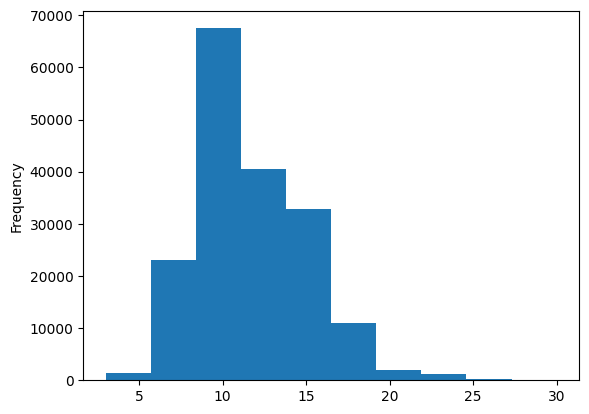

In [ ]:
# Plotting how many lines in each abstract
train_df.total_lines.plot.hist()

## Sentences and Labels

In [ ]:
# Sentences to list
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

In [ ]:
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

### One Hot Encoding

In [ ]:
# Lables- make them numeric
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # default is true and it creates a sparse matrix and trensor flow is incompatible with sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot, train_labels_one_hot.shape

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 (180040, 5))

In [ ]:
train_df["target"].to_numpy().reshape(-1,1).shape

(180040, 1)

In [ ]:
# Lets onehot encode for val labels
# since the one hot encoder is already FIT, we need to use only the transform method

val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

### Label Encoding
Another way to create labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded   = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded  = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded.shape

(180040,)

In [ ]:
# Get class names from Label Encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling Experiments
0. Baseline Model Naive Bayes TF-IDF Encoder Model
1. Conv1D with token embeddings
2. TF Hub Feature Extractor (Maybe USE)
3. Conv1D with character embeddings
4,5 -- New


## Model 0 : Baseline Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create Model 0
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# No Compile, Just fit the model. You cannot pass one hot encoded in SciKit Learn
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Evaluate

In [ ]:
# Score
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score

0.7218323844829869

In [ ]:
# Predict
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Calculate
from helper_functions import calculate_results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 1 : Conv1D with Token Embeddings
The train_sentences is still in text. Needs to be changed to numbers and then embedded. We need to define text vectorizer and an embedding layer

## Text Vectorizer

In [ ]:
# Find Average Sentence Length
len_sentences = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_length = sum(len_sentences)/len(train_sentences)
avg_sentence_length

26.338269273494777

(array([1.0238e+05, 6.5627e+04, 9.5920e+03, 1.8770e+03, 3.9800e+02,
        1.0200e+02, 2.9000e+01, 1.5000e+01, 1.3000e+01, 5.0000e+00,
        0.0000e+00, 2.0000e+00]),
 array([  1.        ,  25.58333333,  50.16666667,  74.75      ,
         99.33333333, 123.91666667, 148.5       , 173.08333333,
        197.66666667, 222.25      , 246.83333333, 271.41666667,
        296.        ]),
 <BarContainer object of 12 artists>)

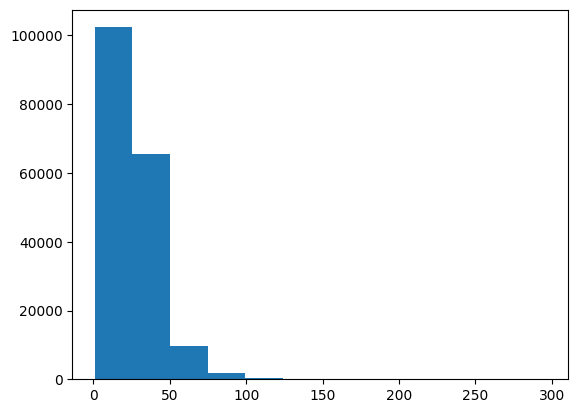

In [ ]:
# What does the distribution look like
import matplotlib.pyplot as plt
plt.hist(len_sentences, bins=12)

In [ ]:
# Find out at what sentence length we cover 95 percent of the train_sentences
# we can use the np.percentile command to get this
import numpy as np

output_seq_len = int(np.percentile(len_sentences, 95))
output_seq_len

55

By keeping the text length at 55, we can make sure 95 percent of the training sentences are fully covered. Vocab size is 68k - given on paper for 20k, for 200k dataset - 331k

In [ ]:
# define variables
max_vocab = 68000
max_length = 55

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_vocab,
                                    output_sequence_length = max_length,
                                    output_mode = "int")

In [ ]:
# We need to adapt the text Vectorizer
text_vectorizer.adapt(train_sentences)

In [ ]:
# Lets take a look at the vocab, since we adapted
train_vocab = text_vectorizer.get_vocabulary()
print(len(train_vocab))
top_5_words = train_vocab[:5]
last_5_words = train_vocab[-5:]
top_5_words, last_5_words

64841


(['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')],
 [np.str_('aainduced'),
  np.str_('aaigroup'),
  np.str_('aachener'),
  np.str_('aachen'),
  np.str_('aaacp')])

In [ ]:
# Lets see a sample of the text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Sample Sentence : {target_sentence}")
print(f"Length is : {len(target_sentence.split())}")
print(f"Vectorized Format \n : {text_vectorizer([target_sentence])}")

Sample Sentence : This observational design will not allow inferences about causality but may reveal clinically important factors that contribute to more effective treatment of IPV .
Length is : 24
Vectorized Format 
 : [[   23  1636   372    95    31  2600 13958   338 10837    72    91  5049
    463   430   254    28  1456     6    69   137    19     4  3694     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# Config of our Text Vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Embedding

In [ ]:
# Create Embedding Layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim=max_vocab,
                                        output_dim=128)

In [ ]:
# Visualize vectorization and embeddings
sample_sentence = "This is a sample sentence for checking vectorization and embedding"

print(f"Original Sentence \n {sample_sentence}")
vectorized_sentence = text_vectorizer([sample_sentence])
print(f"Vectorized Sentence \n {vectorized_sentence}")
print(f"Embedded Sentence \n")
embedded_sentence = token_embed(vectorized_sentence)
print(embedded_sentence)

Original Sentence 
 This is a sample sentence for checking vectorization and embedding
Vectorized Sentence 
 [[   23    20     8   441  9848    11 61684     1     3  8938     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Embedded Sentence 

tf.Tensor(
[[[-0.04481274  0.00572155 -0.00194796 ... -0.03016273 -0.03152929
   -0.00031292]
  [ 0.0024702   0.04458063 -0.02063701 ...  0.02349211  0.00314274
   -0.01475296]
  [-0.04065717  0.04330273 -0.02577412 ... -0.04284731 -0.01376327
   -0.02261351]
  ...
  [-0.04371215 -0.0060331  -0.01204092 ... -0.04721236 -0.02271195
   -0.00098754]
  [-0.04371215 -0.0060331  -0.01204092 ... -0.04721236 -0.02271195
   -0.00098754]
  [-0.04371215 -0.0060331  -0.01204092 ... -0.04721236 -0.02271195
   -0.00098754]]], shape=(1, 5

## Fast Load Datasets : Prefetch

1. Make it to slices using tf.data.Dataset.from_tensor_slices(give as tuple)
2. Turn into batches of 32 and prefetch with autotune

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Build Model 1

In [ ]:
# Create new Model 1 with Conv1D
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
vect_data = text_vectorizer(inputs)
embed_data = token_embed(vect_data)
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(embed_data)
x = layers.GlobalAveragePooling1D(name="global_average_pool_layer")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
# Summary
model_1.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 55, 128)        │     8,704,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pool_layer       │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,745,349 (33.36 MB)

 Trainable params: 8,745,349 (33.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
len(train_dataset)

5627

In [ ]:
len(val_dataset)

945

There are 5627 batches. This is definitely going to take a longggg time for begining testing and see where our model is. Lets train on 10 percent of training dataset and vaidate on 10 percent of validation dataset


In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7752 - loss: 0.6139 - val_accuracy: 0.7670 - val_loss: 0.6581
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7593 - loss: 0.6573 - val_accuracy: 0.7826 - val_loss: 0.6151
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7803 - loss: 0.6029 - val_accuracy: 0.7959 - val_loss: 0.5908
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7925 - loss: 0.5854 - val_accuracy: 0.7922 - val_loss: 0.5719
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7944 - loss: 0.5808 - val_accuracy: 0.7995 - val_loss: 0.5556


In [ ]:
# Evaluate
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8021 - loss: 0.5517


[0.5532143115997314, 0.8036210536956787]

In [ ]:
# Predictions
model_1_pred_probs = model_1.predict(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
model_1_pred_probs.shape

(30212, 5)

For every entry the model predicts a 5 values. we need to find the position of the max value within every line and map it to the class name

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
# Calculate Results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 80.36210777174632,
 'precision': 0.8048189754051792,
 'recall': 0.8036210777174633,
 'f1': 0.8002845952033801}

✅ We are performing better than the baseline model (72 percent vs 80 percent)

# Model 2 : TF Hub - PreTrained Feature Extractor

The feature extractor has pre-trained embeddings as well.

In [ ]:
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

Shape is 512. so it means it denotes every sentence using a 512 dimension

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np

# URL for the Universal Sentence Encoder model
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # or another version

# 1. Define the Input layer
# The input shape should be `()`, indicating a scalar string, and the dtype must be `tf.string`.
input_text = layers.Input(shape=(), dtype=tf.string, name="input_text")

# 2. Use the hub.KerasLayer directly in the functional API
# This layer handles the entire process of loading and applying the USE model.
# Set trainable=False if you don't want to fine-tune the encoder weights.
embedding_layer = hub.KerasLayer(use_url, output_shape=[512], input_shape=(), dtype=tf.string, trainable=False, name='Universal_Sentence_Encoder')

# Connect the input to the embedding layer
embedded_text = embedding_layer(input_text)

# 3. Add subsequent Keras layers
dense_layer = layers.Dense(128, activation='relu')(embedded_text)
output_layer = layers.Dense(1, activation='sigmoid')(dense_layer) # Example output layer for binary classification

# 4. Create the Model
model = Model(inputs=[input_text], outputs=[output_layer])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

TypeError: Exception encountered when calling layer 'Universal_Sentence_Encoder' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None,), dtype=string, sparse=False, ragged=False, name=input_text>,) and kwargs: {} for signature: (inputs: TensorSpec(shape=<unknown>, dtype=tf.string, name=None)).

Call arguments received by layer 'Universal_Sentence_Encoder' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, ragged=False, name=input_text>
  • training=None

In [ ]:
pip install --upgrade tensorflow tensorflow-hub h5py numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.19.1 whic

Model 2 was a failure with debggin on passing data to embedding layer. Spent a day on it.

Moving to Model 3 - Character embeddings

# Model 3 : Conv1D + Character Embedding

Text Vectorizer works on word level
We need to set up a Character Level Tokenizer and then do a character level Embedding

## Prepare Data and Datasets

Basically all we need to do is, use "list" command to separate the text into separate characters and then use ".join" to join them in a single line. we can create a function for it and pass through all train_sentences

In [ ]:
" ".join(list(train_sentences[0]))

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
random_sentence = "hello what is going on here please let me know asap"
split_sentence = split_chars(random_sentence)
len(split_sentence), len(random_sentence)

(101, 51)

In [ ]:
# We need to run through this function into all of train_sentences
train_chars_sentences = [split_chars(sentence) for sentence in train_sentences]
val_chars_sentences = [split_chars(sentence) for sentence in val_sentences]
test_chars_sentences = [split_chars(sentence) for sentence in test_sentences]

## Character Level Tokenizer

In [ ]:
# Calculate
chars_per_sentence = [len(sentence) for sentence in train_sentences]
chars_per_sentence

[281,
 137,
 111,
 65,
 209,
 147,
 161,
 164,
 180,
 51,
 188,
 248,
 79,
 167,
 175,
 245,
 120,
 140,
 163,
 186,
 162,
 191,
 251,
 114,
 70,
 131,
 377,
 93,
 94,
 130,
 125,
 209,
 34,
 90,
 118,
 26,
 124,
 43,
 246,
 285,
 65,
 120,
 131,
 131,
 203,
 245,
 195,
 106,
 110,
 144,
 138,
 87,
 59,
 113,
 102,
 146,
 116,
 108,
 217,
 155,
 107,
 112,
 115,
 59,
 201,
 37,
 204,
 129,
 146,
 154,
 89,
 105,
 90,
 66,
 109,
 65,
 93,
 114,
 103,
 212,
 136,
 86,
 225,
 194,
 89,
 263,
 158,
 407,
 100,
 228,
 193,
 106,
 203,
 134,
 148,
 257,
 268,
 296,
 46,
 90,
 113,
 230,
 262,
 193,
 200,
 37,
 240,
 273,
 98,
 176,
 282,
 101,
 177,
 235,
 337,
 100,
 159,
 222,
 201,
 214,
 79,
 132,
 176,
 133,
 93,
 133,
 122,
 241,
 74,
 96,
 164,
 157,
 61,
 166,
 31,
 94,
 134,
 188,
 63,
 128,
 123,
 81,
 38,
 77,
 68,
 120,
 91,
 109,
 108,
 150,
 108,
 265,
 207,
 140,
 270,
 123,
 63,
 161,
 196,
 86,
 272,
 116,
 218,
 48,
 156,
 64,
 492,
 159,
 169,
 206,
 237,
 111,
 126,
 102,

In [ ]:
# Average chars per sentence
avg_chars = sum(chars_per_sentence)/len(train_sentences)
avg_chars

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

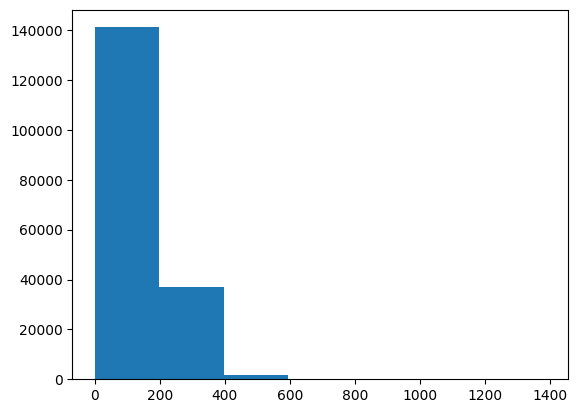

In [ ]:
# Plot and see the spread
import matplotlib.pyplot as plt
plt.hist(chars_per_sentence, bins=7)

Above histogram chart shows the maximum character length is around 1400. but the range which covers most of the sentences lies between 200 and 400. We need to find out the average character length for 95 percent of the sentences. We can use np.percentile for that

In [ ]:
import numpy as np

avg_sentence_length_95 = int(np.percentile(chars_per_sentence, 95))
avg_sentence_length_95

290

Now we can safely assume that if we give the output of text vectorizer with maximum length - 290, then that covers 95 percent of the train_sentences. Next is to find the max vocab for the characters.

For characters,
1. Number of alphabets in lower case (26)
2. special characters
3. punctuations

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
len(alphabet)

68

We have all the details required for creating the character level vectorizer
Max Char Length = 68
Output Sequence Length = 290

In [ ]:
# Create Character Level Vectorizer
import tensorflow as tf

char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = len(alphabet),
                                                    output_sequence_length = avg_sentence_length_95,
                                                    name = "char_vectorizer")

In [ ]:
# Adapt it ************** very important , else will error at Fit*******
char_vectorizer.adapt(train_chars_sentences)

In [ ]:
# Convert them to datasets, batch them and prefetch
import tensorflow as tf

train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


## Embedding
Now that we have created the vectorizer, next we need to create the Embedder

In [ ]:
# Create Embedding Layer
char_embed = tf.keras.layers.Embedding(input_dim = len(alphabet),
                                       output_dim = 25)

## Build Model

In [ ]:
# Creating a Conv1D Model with Character Level Embedding
import tensorflow as tf

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
char_vects = char_vectorizer(inputs)
char_embeds = char_embed(char_vects)
x = tf.keras.layers.Conv1D(128, kernel_size = 15, activation="relu", padding="same")(char_embeds)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x)

model_3 = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
# Check Summary
model_3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 290, 25)        │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 290, 128)       │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,473 (197.16 KB)

 Trainable params: 50,473 (197.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit data
history_model_3 = model_3.fit(train_chars_dataset,
                              epochs =5,
                              steps_per_epoch = int(0.1* len(train_chars_dataset)),
                              validation_data = val_chars_dataset,
                              validation_steps = int(0.1 * len(val_chars_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3437 - loss: 1.4519 - val_accuracy: 0.4302 - val_loss: 1.3390
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4409 - loss: 1.3359 - val_accuracy: 0.4648 - val_loss: 1.2985
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4640 - loss: 1.2990 - val_accuracy: 0.4668 - val_loss: 1.2789
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4729 - loss: 1.2741 - val_accuracy: 0.4884 - val_loss: 1.2415
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.2434 - val_accuracy: 0.5123 - val_loss: 1.2117


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# Evaluate
model_3.evaluate(val_chars_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5065 - loss: 1.2163


[1.2181304693222046, 0.5057262182235718]

In [ ]:
# Pred Probs
model_3_pred_probs = model_3.predict(val_chars_dataset)
model_3_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[0.29965264, 0.25452444, 0.16813819, 0.23445788, 0.04322682],
       [0.15122208, 0.21415552, 0.16551815, 0.07257835, 0.39652595],
       [0.20954762, 0.16330612, 0.39820468, 0.19237563, 0.03656603],
       [0.01617571, 0.02747315, 0.8873936 , 0.04057864, 0.02837901],
       [0.14051747, 0.1664333 , 0.38138062, 0.14293727, 0.1687313 ],
       [0.07610286, 0.07272219, 0.59950054, 0.02897215, 0.22270226],
       [0.09653721, 0.1135353 , 0.4750326 , 0.04595117, 0.2689438 ],
       [0.30969778, 0.2571846 , 0.16943261, 0.11792141, 0.14576364],
       [0.01916618, 0.0973893 , 0.05560854, 0.11635611, 0.71147984],
       [0.10055346, 0.2104041 , 0.22151539, 0.3573464 , 0.11018059]],
      dtype=float32)

In [ ]:
model_3_pred_probs.shape

(30212, 5)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 4, 2, 2, 2, 2, 2, 0, 4, 3])>

In [ ]:
# Calculate results
from helper_functions import calculate_results

model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 50.5726201509334,
 'precision': 0.4719085705082179,
 'recall': 0.505726201509334,
 'f1': 0.4680719516529673}

# Model 4 : Combine Embeddings, Add Dropouts

We are going to combine the token level embeddings + character level embeddings and add a dropout

Dropout : basically drops a percentage of the learnt weights.

We are replicating this model as per the paper

n moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

1. Model for token embeddings
2. Model for character embeddings
3. Combine Both using layers.Concatenate
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

## Build

In [ ]:
# 1. Build Model with Token Embedding
import tensorflow as tf
from tensorflow.keras import layers

input_tokens = layers.Input(shape=(1,), dtype=tf.string, name="input_token_layer")
tokens_vect = text_vectorizer(input_tokens)
tokens_embed = token_embed(tokens_vect)
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(tokens_embed)
output_tokens = layers.GlobalMaxPool1D()(x)
token_model = tf.keras.Model(inputs=input_tokens,
                             outputs=output_tokens)

# 2. Build Model with Character Embedding
input_chars = layers.Input(shape=(1,), dtype=tf.string, name="input_char_layer")
chars_vect = char_vectorizer(input_chars)
chars_embed = char_embed(chars_vect)
output_chars = layers.Bidirectional(layers.LSTM(25))(chars_embed)
chars_model = tf.keras.Model(inputs=input_chars,
                             outputs=output_chars)

# 3.Concatenate
concat_output = layers.Concatenate(name="concat_layer")([token_model.output,
                                                         chars_model.output])

# 4. Create Output layers : dropout first, output, final dropout, final output
first_dropout = layers.Dropout(0.5)(concat_output)
first_dense = layers.Dense(100, activation="relu")(first_dropout)
final_dropout = layers.Dropout(0.5)(first_dense)
final_output = layers.Dense(5, activation="softmax", name="final_output")(final_dropout)

# 5. Build Model
model_4 = tf.keras.Model(inputs=[token_model.input, chars_model.input],
                         outputs=final_output,
                         name="model_4_token_char_embeddings")

In [ ]:
# Summary
model_4.summary()

Model: "model_4_token_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_token_layer   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 55)        │          0 │ input_token_laye… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_char_layer    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 55, 128)   │  8,704,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ input_char_layer… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 55, 64)    │     41,024 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 290, 25)   │      1,700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_28[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 50)        │     10,200 │ embedding_8[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 114)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 114)       │          0 │ concat_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100)       │     11,500 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 100)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 5)         │        505 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,768,929 (33.45 MB)

 Trainable params: 8,768,929 (33.45 MB)

 Non-trainable params: 0 (0.00 B)

## Summary

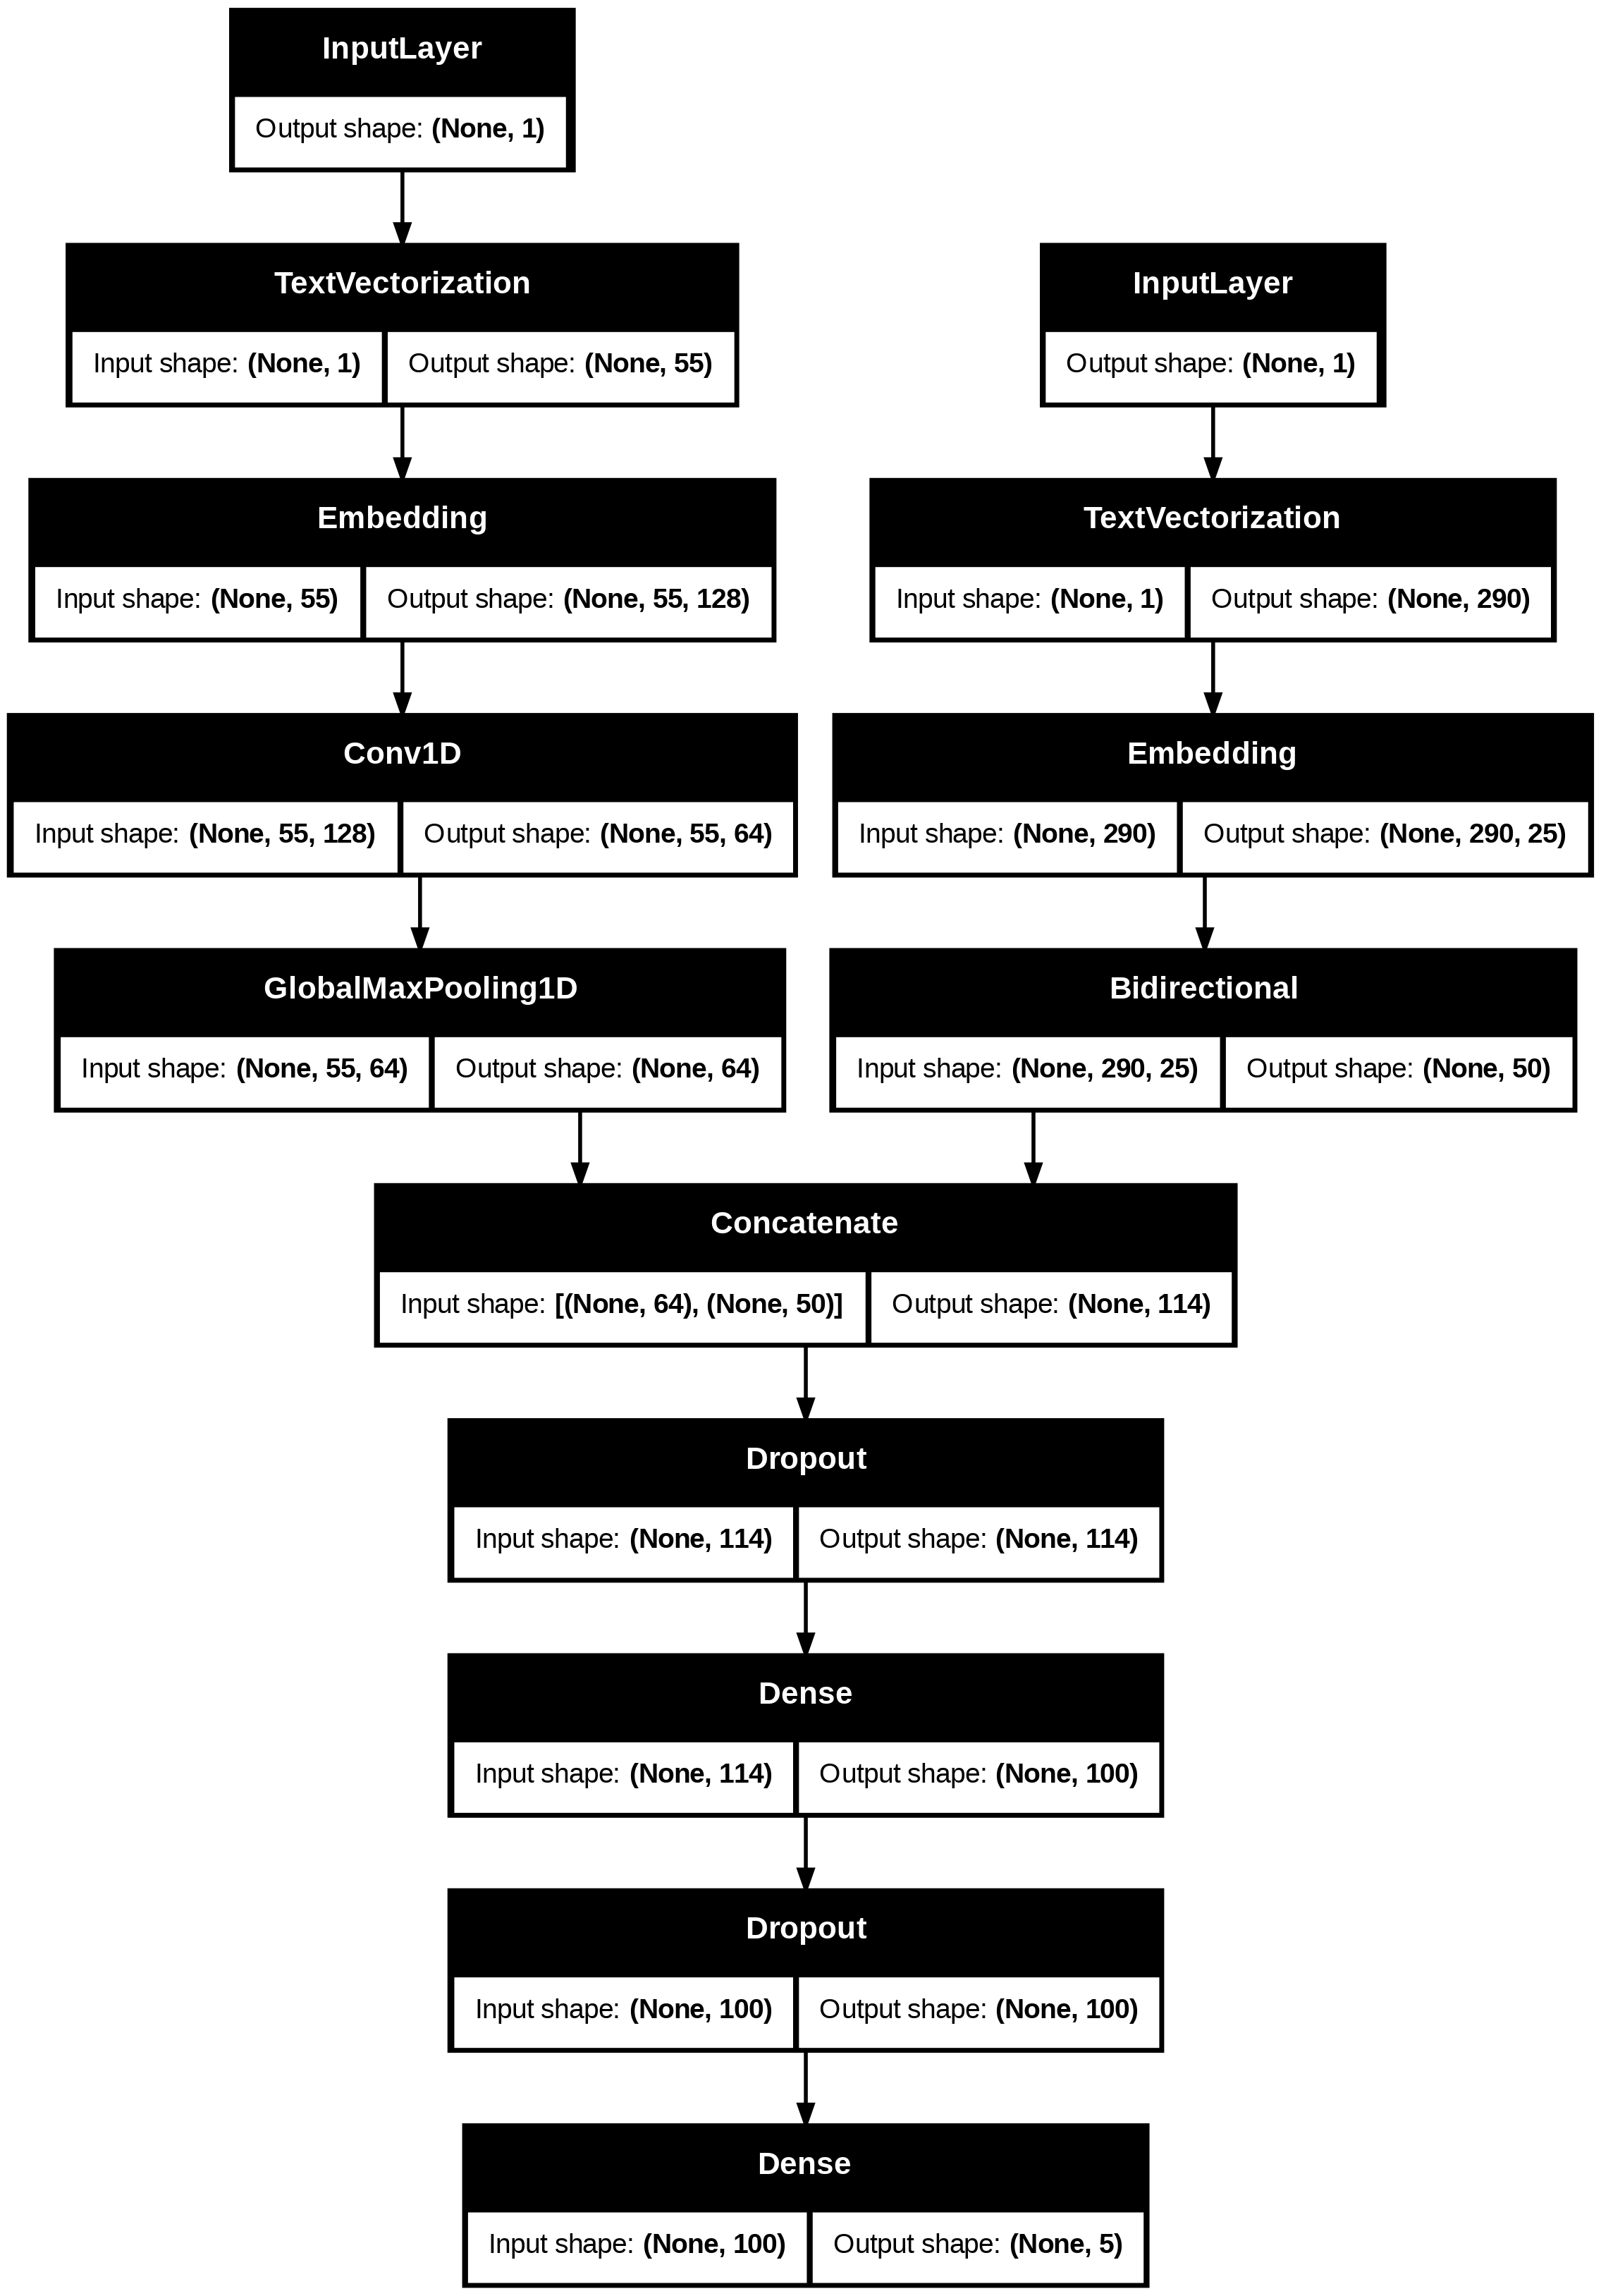

In [ ]:
# Utils
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

## Compile

In [ ]:
# Compile the Model4
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Prep Datasets
Currently we have train_sentences for token level as input and we have train_chars_sentences for char level input, we need to combine these both and then combine that with train_labels_one hot

How to do it ?
1. use tf.data.Dataset.from_tensor_slices to make datasets of train sentences and train char sentences

2. use tf.data.Dataset.from_tensor_slices to make a dataset of train labels one hot encoded

3. use tf.data.Dataset.zip to combine the above 2

In [ ]:
# Combine Token and Chars for Training Data
train_char_token_sentences = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars_sentences))
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_sentences, train_labels_dataset))

<_ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# For Validation Data
val_char_token_sentences = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars_sentences))
val_labels_dataset = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_sentences, val_labels_dataset))

In [ ]:
# For Testing Data
test_char_token_sentences = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars_sentences))
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_sentences, test_labels_dataset))

In [ ]:
# Batch and Prefetch
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Visualizee
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fit

In [ ]:
# fit
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=5,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4728 - loss: 1.2492 - val_accuracy: 0.7633 - val_loss: 0.6466
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.7374 - loss: 0.7213 - val_accuracy: 0.7936 - val_loss: 0.5813
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.7552 - loss: 0.6704 - val_accuracy: 0.7989 - val_loss: 0.5732
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7607 - loss: 0.6596 - val_accuracy: 0.7939 - val_loss: 0.5510
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.7696 - loss: 0.6409 - val_accuracy: 0.7926 - val_loss: 0.5488


In [ ]:
# Evaluate
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7963 - loss: 0.5431


[0.5444964170455933, 0.7995167374610901]

In [ ]:
# Predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


array([[5.1177388e-01, 2.2351398e-01, 5.5705927e-02, 1.9670120e-01,
        1.2305027e-02],
       [3.2028306e-01, 5.6980759e-01, 2.8941357e-03, 9.8801397e-02,
        8.2138181e-03],
       [4.6712783e-01, 5.9659131e-02, 1.1985517e-02, 4.5906207e-01,
        2.1653736e-03],
       ...,
       [3.3912722e-05, 2.2884377e-03, 8.5168127e-03, 8.7007738e-06,
        9.8915219e-01],
       [3.7287068e-02, 3.2979041e-01, 6.7901373e-02, 1.2369504e-02,
        5.5265164e-01],
       [1.2918231e-01, 8.1489861e-01, 2.1824574e-03, 1.5437748e-02,
        3.8298886e-02]], dtype=float32)

In [ ]:
# Preds
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [ ]:
# Calculate
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 79.9516748311929,
 'precision': 0.8101632386057414,
 'recall': 0.799516748311929,
 'f1': 0.7960828323904054}

# Model 5 : Token + Char + Positional Embeddings

## Background/ Reasoning

Till now we loaded records sequentially for every abstract.
But we need to tell the model that within an abstract the objective, background, inference and conclusion belong within the same abstract - Feature Engineering

We already know some information, we are feeding and training that information to the model in a slightly tweaked way so that it can understand the nuances better

Data Augmentation is one of the Feature Engineering. We zoomed, sheared, shifted the image and trained the model to tell its the same image.

Similarly we need to feature engineer the text

Its called **Positional Embeddings**
We have line numbers from 0 to end of abstract say 12. May be we can tell the model that the line number can be used to understand the sequence of the abstract

✅ Any features which we are going to pick for Positional Embedding should also be available during Testing. It cannot be available only durring training.

If we pick Line number and total number of lines - then these 2 fields will also be available for any test data

## Positional Embeddings

In [ ]:
# lets pick the line numbers
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


In [ ]:
train_df.line_number.value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


(array([4.5000e+04, 4.4941e+04, 4.2383e+04, 2.9914e+04, 1.2840e+04,
        3.8000e+03, 9.1000e+02, 2.0000e+02, 4.3000e+01, 9.0000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

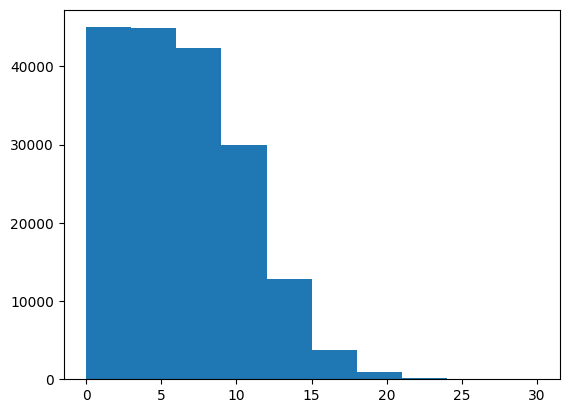

In [ ]:
# plot
import matplotlib.pyplot as plt

plt.hist(train_df["line_number"])

We see that most most abstracts have 15 lines as max. so lets go with a depth of 15 for one hot encoding this column

In [ ]:
# One Hot encode using tf.onehot the line number
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# check those with greater than 15 line number to see what was one hot encoded
cond_line_number = train_df["line_number"] > 15
filtered_df = train_df[cond_line_number]
filtered_df

,target,text,line_number,total_lines
54,BACKGROUND,Data management and statistical analyses were ...,16,16
134,BACKGROUND,Current Controlled Trial NCT@ .,16,16
258,CONCLUSIONS,"In addition , minimal disruption of normal gut...",16,19
259,CONCLUSIONS,These results support the further clinical dev...,17,19
260,BACKGROUND,Current Controlled Trials .,18,19
...,...,...,...,...
179955,CONCLUSIONS,Oxygen therapy delivered by bubble CPAP improv...,17,21
179956,CONCLUSIONS,Use of bubble CPAP oxygen therapy could have a...,18,21
179957,CONCLUSIONS,The trial was stopped early because of higher ...,19,21
179958,CONCLUSIONS,Further research is needed to test the feasibi...,20,21


In [ ]:
# check for totals across last axis. This should show either 1(most cases) or zero
train_line_numbers_one_hot_row_sums = tf.reduce_sum(train_line_numbers_one_hot, axis=-1)
train_line_numbers_one_hot_row_sums
# Amongst the above result check the rows which have total zero
# This gives report for all rows with value True (if sum is zero) OR False
train_line_numbers_one_hot_zero_rows = tf.equal(train_line_numbers_one_hot_row_sums, 0)

zero_indices = tf.where(train_line_numbers_one_hot_zero_rows)
zero_indices[:50]

train_line_numbers_one_hot[53]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
# Do same for Val and test
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <BarContainer object of 10 artists>)

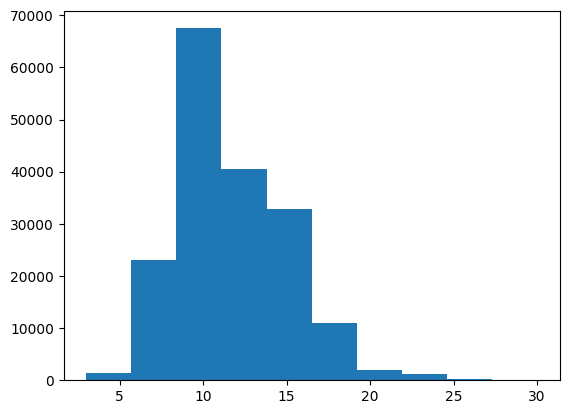

In [ ]:
# Total Lines
plt.hist(train_df["total_lines"])

In [ ]:
# lets find spread
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


In [ ]:
# Percentile
np.percentile(train_df.total_lines, 98)

np.float64(20.0)

If we decide to go with a depth of 20, then we can cover 98 percent of the data

In [ ]:
# One Hot encode the total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

## Build

1. Token Level Model Creation
2. Char Level Model Creation
3. Line Number Feature Model Creation
4. Total Lines Feature Model Creation
5. Concatenate 1 and 2
   Also perform a dropout of the combined embeddings (token+char)
6. Concatenate 3,4 and 5
7. Create Output Layer
8. Create the Model with Inputs from 1,2,3,4 and Output from 7

In [ ]:
import tensorflow as tf

# Token Level Model creation
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_input_layer")
vect_data = text_vectorizer(token_inputs)
embedded_data = token_embed(vect_data)
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(embedded_data)
token_outputs = layers.GlobalMaxPool1D()(x)

token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Character Level Model Creation
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input_layer")
char_vect_data = char_vectorizer(char_inputs)
char_embed_data = char_embed(char_vect_data)
char_outputs = layers.Bidirectional(layers.LSTM(25))(char_embed_data)

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

# Line Number feature Model Creation
line_num_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_num_input_layer")
x = layers.Dense(32, activation="relu")(line_num_inputs)

line_num_model = tf.keras.Model(inputs=line_num_inputs,
                                outputs=x)

# Total Lines Model Creation
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input_layer")
y = layers.Dense(32, activation="relu")(total_lines_inputs)

total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# Concatenate Token Embeddings Output and Char Model Embeddings Output
char_token_embeddings = layers.Concatenate(name="char_token_embedding_layer")([token_model.output,
                                                                        char_model.output])
z = layers.Dense(100, activation="relu")(char_token_embeddings)
z = layers.Dropout(0.5)(z)

# Concatenate Combined Embeddings with Positional Embeddings
tribrid_embeddings = layers.Concatenate(name="cchar_token_pos_embedding_layer")([line_num_model.output,
                                                                                total_lines_model.output,
                                                                                z])
# Output Layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# Model
model_5 = tf.keras.Model(inputs=[line_num_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)



In [ ]:
# Summary
model_5.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input_layer   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 55)        │          0 │ token_input_laye… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input_layer    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 55, 128)   │  8,704,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input_layer… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 55, 64)    │     41,024 │ embedding_7[9][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 290, 25)   │      1,700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_36[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 50)        │     10,200 │ embedding_8[7][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_embeddi… │ (None, 114)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_num_input_lay… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input_… │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 100)       │     11,500 │ char_token_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │        512 │ line_num_input_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 100)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cchar_token_pos_em… │ (None, 164)       │          0 │ dense_19[0][0],   │
│ (Concatenate)       │                   │            │ dense_20[0][0],   │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │        825 │ cchar_token_pos_

 Total params: 8,770,433 (33.46 MB)

 Trainable params: 8,770,433 (33.46 MB)

 Non-trainable params: 0 (0.00 B)

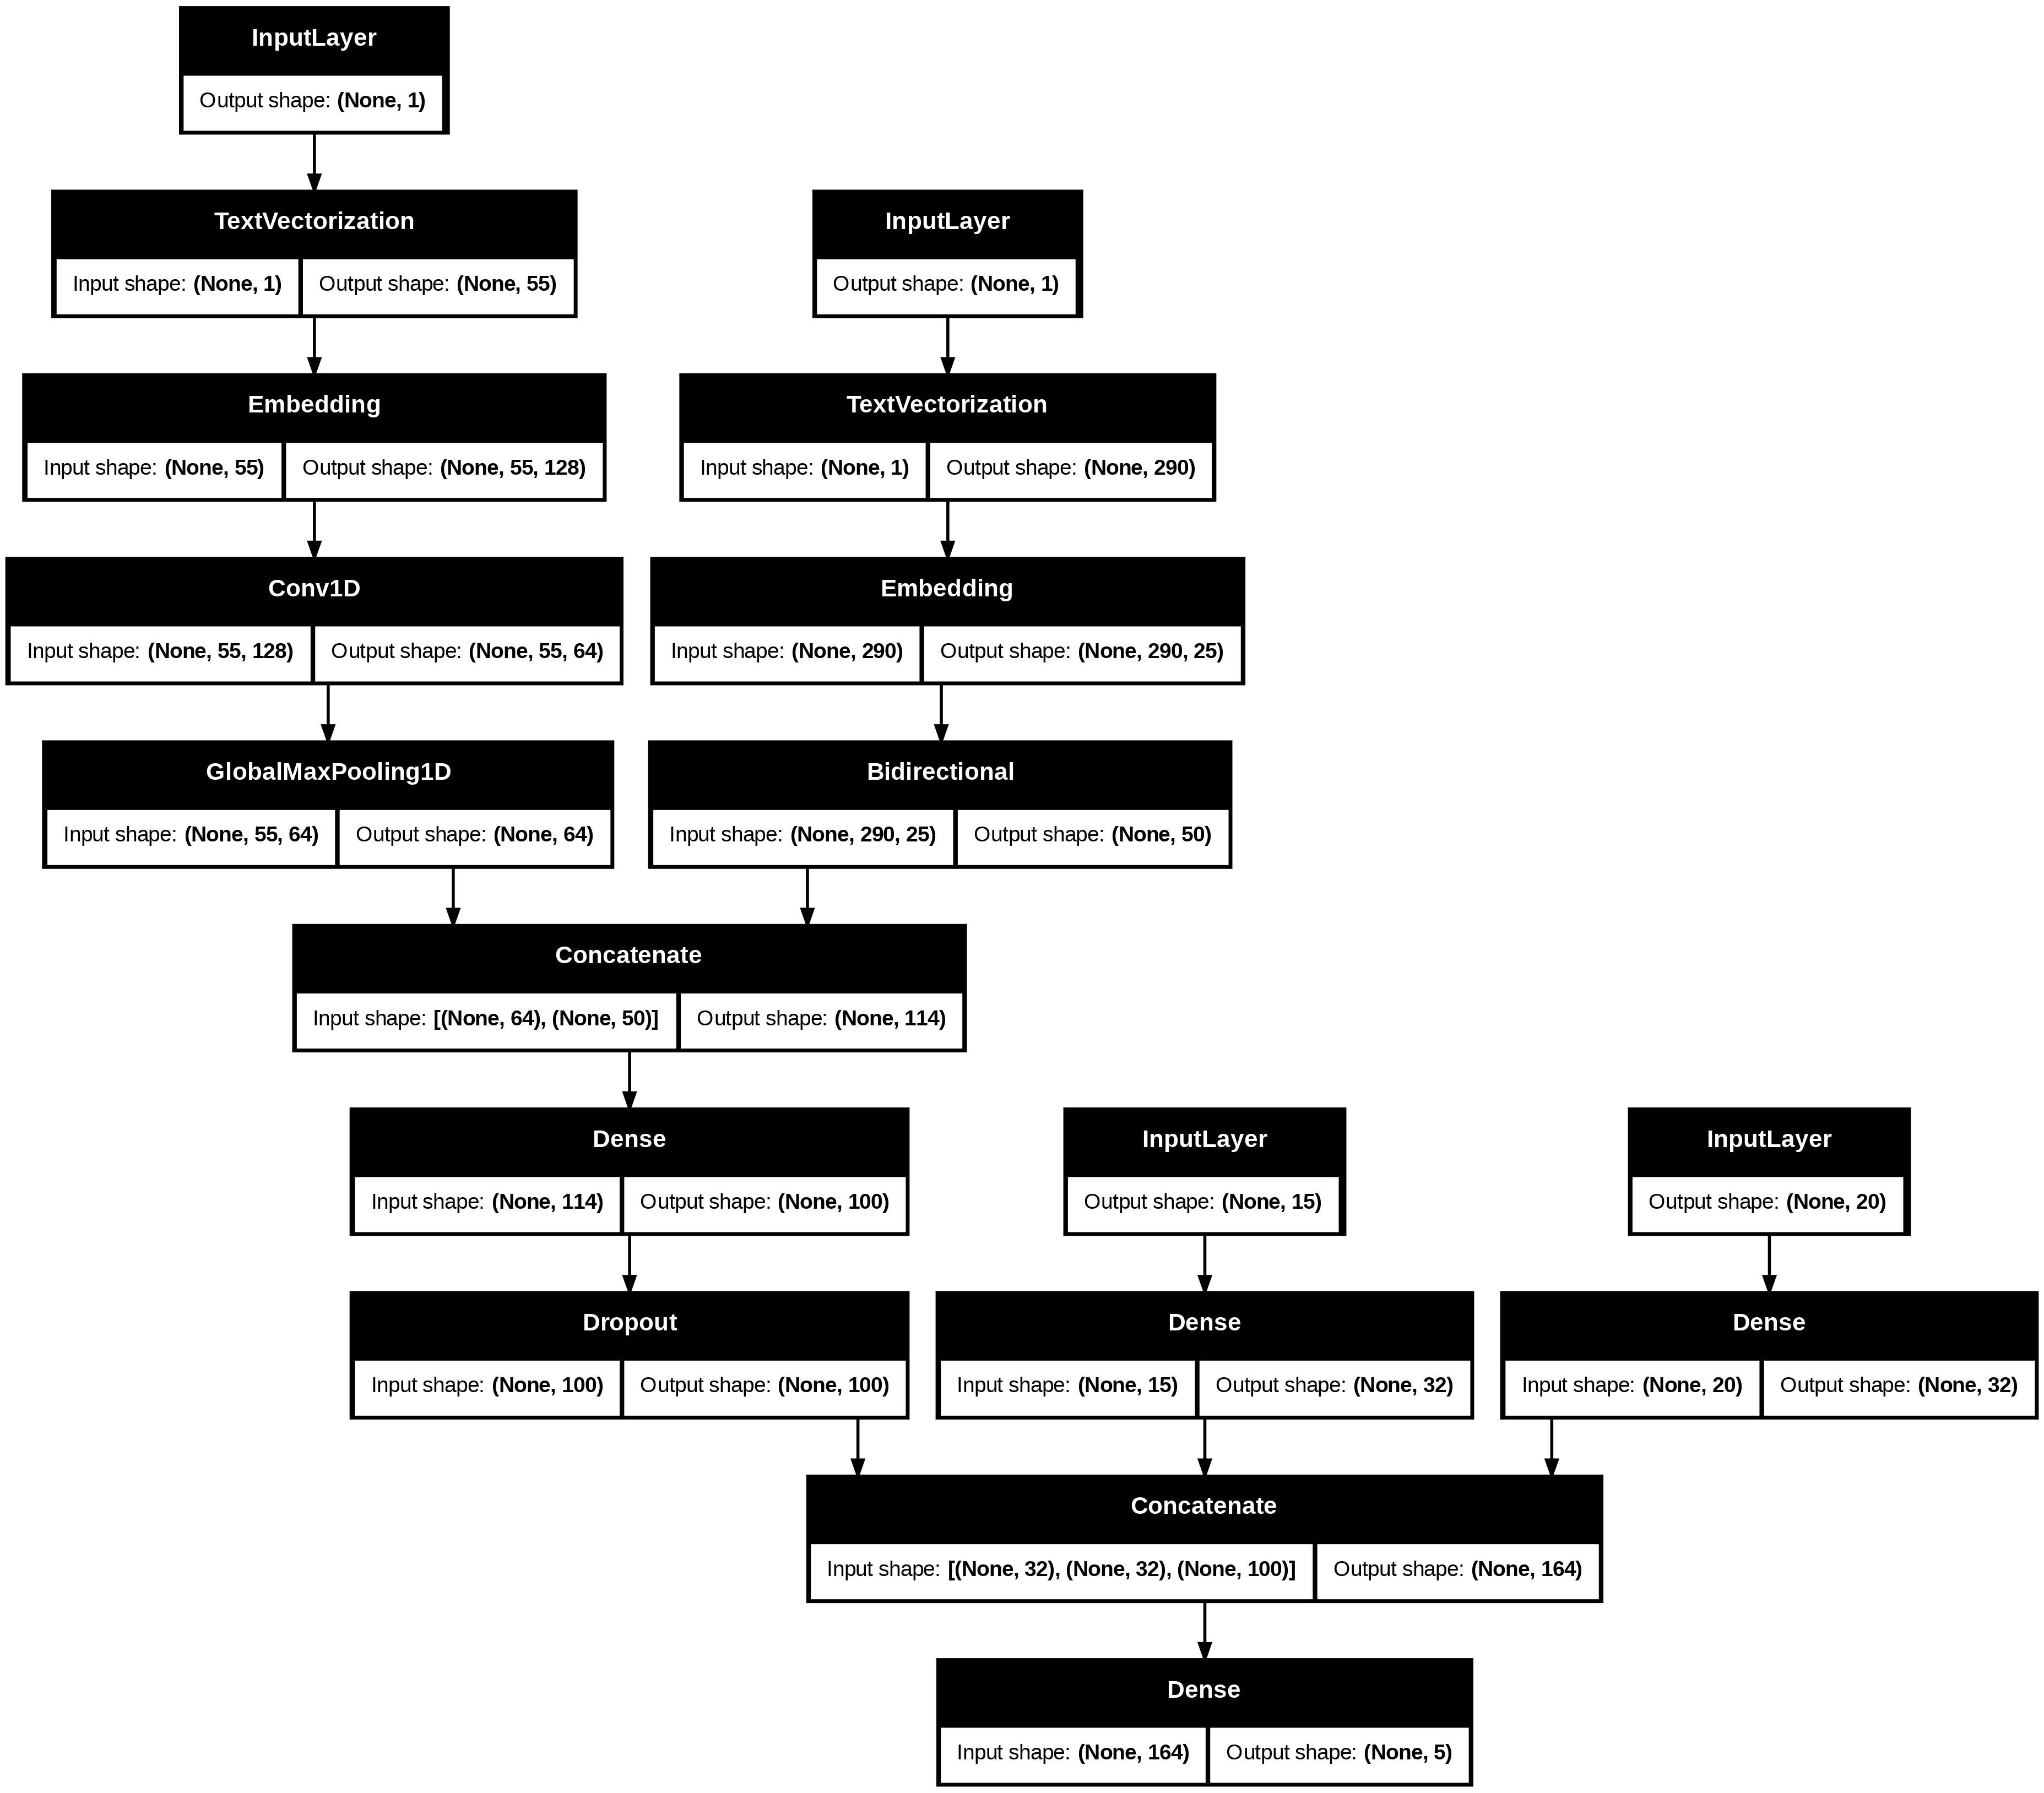

In [ ]:
# Plot
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Label Smoothing
✅ Say a model is very confident on a specific class and starts predicting 1 for that class, something like
[0., 0., 0., 1., 0.]
Above means the model is very confident on a specific class, in above case class = 3, so it assigns all others to zero.

Even though this seems good, it is NOT

The Model starts to develop a **Tunnel Vision** for this class and stops learning/ assigning some learning of this class to other classes. Hence we need to use label smoothing

Label Smoothing is built in with "Categorical CrossEntropy" hence it is always better to one hot encode to use the label smoothing feature available while compiling

When Label Smoothing happens, the output prediction becomes something like
[0.01, 0.01, 0.01, 0.96, 0.01]

a little preds from the confident label is taken away and this makes sure the model continually learns and avoids a **tunnel vision**

Float in [0, 1]. When > 0, label values are smoothed, meaning the confidence on label values are relaxed. For example, if 0.1, use 0.1 / num_classes for non-target labels and 0.9 + 0.1 / num_classes for target labels.

## Prepare Datasets

In [ ]:
# Looking at the order the inputs were given - line num, total lines, token, char
train_line_total_token_char = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                  train_total_lines_one_hot,
                                                                  train_sentences,
                                                                  train_chars_sentences))
train_line_total_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_line_total_token_char_dataset = tf.data.Dataset.zip((train_line_total_token_char,
                                                           train_line_total_token_char_labels))
train_line_total_token_char_dataset = train_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Validation
val_line_total_token_char = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars_sentences))
val_line_total_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_line_total_token_char_dataset = tf.data.Dataset.zip((val_line_total_token_char,
                                                         val_line_total_token_char_labels))
val_line_total_token_char_dataset = val_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Test
test_line_total_char_token = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                 test_total_lines_one_hot,
                                                                 test_sentences,
                                                                 test_chars_sentences))
test_line_total_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_line_total_char_token_dataset = tf.data.Dataset.zip((test_line_total_char_token,
                                                          test_line_total_char_token_labels))
test_line_total_char_token_dataset = test_line_total_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_line_total_token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Fit

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_line_total_token_char_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_line_total_token_char_dataset)),
                              validation_data = val_line_total_token_char_dataset,
                              validation_steps = int(0.1*len(val_line_total_token_char_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6797 - loss: 1.1493 - val_accuracy: 0.8428 - val_loss: 0.9181
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8645 - loss: 0.9149 - val_accuracy: 0.8507 - val_loss: 0.9108
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.8648 - loss: 0.9007 - val_accuracy: 0.8517 - val_loss: 0.8995
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.8742 - loss: 0.8903 - val_accuracy: 0.8507 - val_loss: 0.8982
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8717 - loss: 0.8879 - val_accuracy: 0.8640 - val_loss: 0.8935


In [ ]:
# Evaluate
model_5.evaluate(val_line_total_token_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8659 - loss: 0.8879


[0.8891730904579163, 0.8664106726646423]

In [ ]:
# Predict
model_5_pred_probs = model_5.predict(val_line_total_token_char_dataset)


945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step


array([[0.49038884, 0.11443631, 0.03195648, 0.31974018, 0.04347817],
       [0.4962773 , 0.10801095, 0.0957081 , 0.25601226, 0.04399139],
       [0.32988855, 0.14741476, 0.0654695 , 0.4256103 , 0.03161699],
       [0.01805867, 0.02811342, 0.9159474 , 0.01845916, 0.0194214 ],
       [0.0276659 , 0.05620928, 0.7459577 , 0.02829683, 0.14187026]],
      dtype=float32)

In [ ]:
# Calculate
model_5_preds = tf.argmax(model_5_pred_probs, axis=-1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 86.6410697735999,
 'precision': 0.8701816486256325,
 'recall': 0.866410697735999,
 'f1': 0.8626992580278112}